In [1]:
import io
import base64
import glob
import os
import cv2
import sys
import importlib
import torchvision
import matplotlib.pyplot as plt

import gzip
import json
import numpy as np
import torch
from IPython.display import HTML
from skvideo.io import FFmpegReader, ffprobe, vwrite
from torch.autograd import Variable
from ptcap.trainers import DataParallelWrapper
from ptcap.grad_cam_videos import GradCam
from ptcap.data.annotation_parser import V2Parser

sys.path.insert(0, "../")

/home/farzaneh/venv/ptcap/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


## Load Model

In [2]:
from ptcap.model.captioners import EncoderDecoder
from ptcap.model.encoders import C3dLSTMEncoder
from ptcap.model.two_stream_encoders import TwoStreamEncoder
from ptcap.model.external_encoders import FCEncoder, JesterEncoder, BIJesterEncoder
from ptcap.model.decoders import LSTMDecoder, CoupledLSTMDecoder

net = EncoderDecoder(
        encoder=TwoStreamEncoder,
        decoder=CoupledLSTMDecoder,
        encoder_kwargs={"encoder_output_size": 1024,"c2d_out_ch": 32,
                   "c3d_out_ch": 0, "rnn_output_size":1024},#, "pretrained_path": "/home/farzaneh/PycharmProjects/pretrained_nets/fully_conv_net_on_smtsmt_20170627/model.checkpoint"},
        decoder_kwargs={"embedding_size": 256, "hidden_size": 1024, "num_lstm_layers": 2, 
        "vocab_size": 2728, "num_step" :17, "fc_size":1024}, 
        gpus=[0]).cuda()
net = DataParallelWrapper(net, device_ids=[0]).cuda(0)

gpus: [0]


In [3]:
# path = '/home/farzaneh/PycharmProjects/pytorch-captioning/results/clapnet_balanced_tokens/'
path = '/home/farzaneh/PycharmProjects/pytorch-captioning/results/v2_c3d_0_c2_32_labels_classif1_cap0'

checkpoint = torch.load(path + '/model.best')


net.load_state_dict(checkpoint["model"])
#checkpoint["model"].keys()

## Load Data

In [4]:
validation_path = "/data/20bn-something-something-v2/v2-validation.json"
videos_folder = "/data-ssd/v2-gulp-160/"
caption_type = "label"

validation_parser = V2Parser(validation_path,
                                            videos_folder,
                               caption_type=caption_type)

In [5]:
def path_generator(annotation_path, root_path):
    with open(annotation_path, "rt") as f:
        annotations = json.load(f)
    files = validation_parser.get_video_paths()
    labels = validation_parser.get_captions()
    return ((os.path.join(root_path, f), label) for f, label in zip(files, labels))
path_gen = path_generator('/data/20bn-something-something-v2/v2-train.json', 
                          '/data/20bn-something-something-v2/')



In [6]:
from rtorchn.data.fileio import MpegReader

reader = MpegReader(12, (128, 128), keep_aspect_ratio=False)

## Preprocessing

In [7]:
from rtorchn.data.preprocessing import default_evaluation_preprocesser

preprocessor = default_evaluation_preprocesser([48, 96, 96], 64.)

## Tokenizer

In [8]:
from ptcap.data.tokenizer import Tokenizer

USER_MAXLEN=17
tokenizer = Tokenizer(user_maxlen=USER_MAXLEN)
tokenizer.load_dictionaries(path)

## Model Layers

In [9]:
def run_model():
    gradients = []


    h = net.module.encoder.c2d_extractor.conv1(video)
    h = net.module.encoder.c2d_extractor.pool1(h)

    h = net.module.encoder.c2d_extractor.conv2(h)
    h = net.module.encoder.c2d_extractor.pool2(h)

    h = net.module.encoder.c2d_extractor.conv3(h)
    h = net.module.encoder.c2d_extractor.pool3(h)  

    feats = net.module.encoder.c2d_extractor.conv4(h)  

    feats.register_hook(lambda grad:gradients.append(grad))
    #feats = h

    h = net.module.encoder.c2d_extractor.conv5(feats)   
    h = net.module.encoder.c2d_extractor.conv6(h)   

    h = net.module.encoder.c2d_extractor.pool4(h)   

    h = h.view(h.size()[0:3])   
    h = h.permute(0, 2, 1)   

    net.module.encoder.lstm.flatten_parameters()
    h, _ = net.module.encoder.lstm(h) 

    dec = net.module.decoder(h, Variable(torch.zeros([1, 1])).long().cuda())
    return dec, gradients

## CAM calculating

In [10]:
def calc_cam(token_index)

    one_hot = np.zeros((1, 2728), dtype=np.float32)
    one_hot[0][token_index] = 1
    one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
    one_hot = torch.sum(one_hot.cuda() * dec[:,0,:])
    net.module.encoder.c2d_extractor.conv4.zero_grad()
    #net.module.classif_layer.zero_grad()
    one_hot.backward(retain_graph=True)
    grads_val = gradients[0].cpu().data.numpy() #take the only element out of gradients list
    feats_numpy = feats.cpu().data.numpy()[0, :] #first sample of batch
    weights = np.mean(grads_val, axis=(2, 3, 4))[0, :]   #grads_val: (1, 256, 48, 10, 10)
    cam = np.ones(feats_numpy.shape[1:], dtype=np.float32)
    weights = weights / weights.max()
    for ii, ww in enumerate(weights):
        cam += ww * feats_numpy[ii, :, :, :]

SyntaxError: invalid syntax (<ipython-input-10-37efe3fe8bb1>, line 1)

In [11]:
cam = np.maximum(cam, 0)

NameError: name 'cam' is not defined

In [47]:

path_to_video, label = next(path_gen)

video_uint8 = reader.open(path_to_video)
# Preprocessing
video = preprocessor(video_uint8)
# Convert to torch variable
video = Variable(torch.from_numpy(video[None]), volatile=False).cuda()

tokens = tokenizer.encode_caption(label)


In [48]:

##modedl
gradients = []


h = net.module.encoder.c2d_extractor.conv1(video)
h = net.module.encoder.c2d_extractor.pool1(h)

h = net.module.encoder.c2d_extractor.conv2(h)
h = net.module.encoder.c2d_extractor.pool2(h)

h = net.module.encoder.c2d_extractor.conv3(h)
h = net.module.encoder.c2d_extractor.pool3(h)  

feats = net.module.encoder.c2d_extractor.conv4(h)  

feats.register_hook(lambda grad:gradients.append(grad))
#feats = h

h = net.module.encoder.c2d_extractor.conv5(feats)   
h = net.module.encoder.c2d_extractor.conv6(h)   

h = net.module.encoder.c2d_extractor.pool4(h)   

h = h.view(h.size()[0:3])   
h = h.permute(0, 2, 1)   

net.module.encoder.lstm.flatten_parameters()
h, _ = net.module.encoder.lstm(h) 

dec = net.module.decoder(h, Variable(torch.zeros([1, 1])).long().cuda())


    

Holding a pen in front of a microwave
['HOLDING']
***************


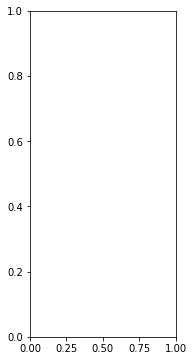

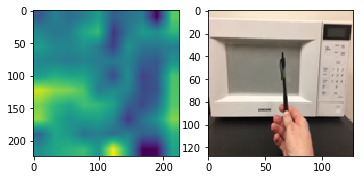

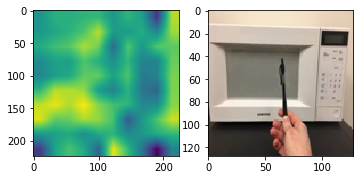

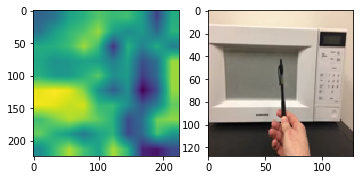

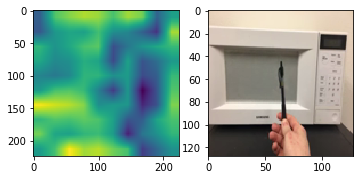

['A']
***************


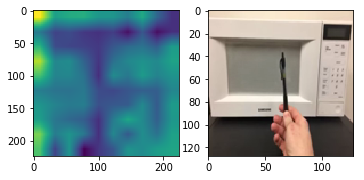

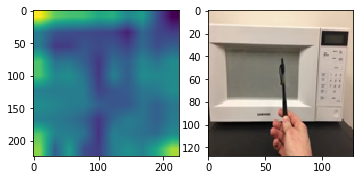

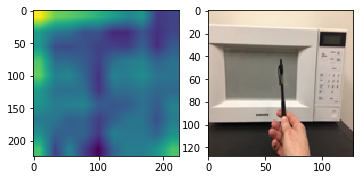

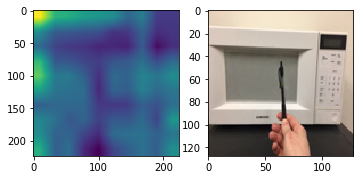

['PEN']
***************


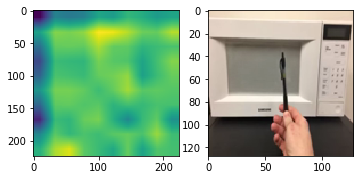

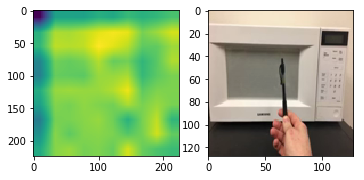

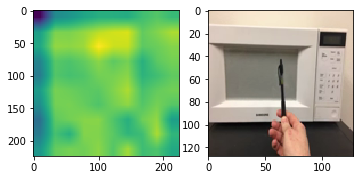

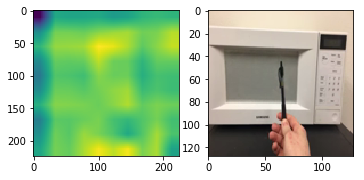

['IN']
***************


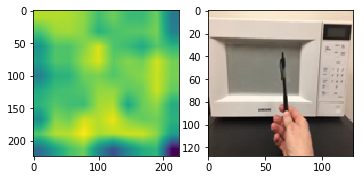

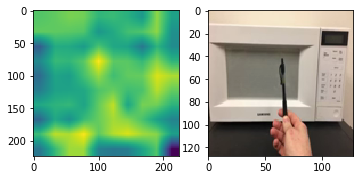

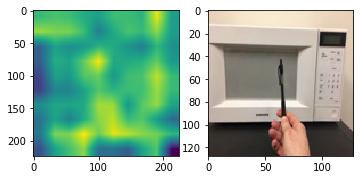

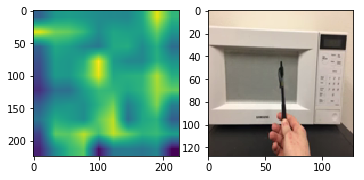

In [67]:
path_to_video, label = next(path_gen)

video_uint8 = reader.open(path_to_video)
video = preprocessor(video_uint8)
video = Variable(torch.from_numpy(video[None]), volatile=False).cuda()
tokens = tokenizer.encode_caption(label)


print(label)

for tt in range(0,4):
    token_index = tokens[tt]
    
    ##model
    gradients = []
    h = net.module.encoder.c2d_extractor.conv1(video)
    h = net.module.encoder.c2d_extractor.pool1(h)
    h = net.module.encoder.c2d_extractor.conv2(h)
    h = net.module.encoder.c2d_extractor.pool2(h)
    h = net.module.encoder.c2d_extractor.conv3(h)
    h = net.module.encoder.c2d_extractor.pool3(h)  
    feats = net.module.encoder.c2d_extractor.conv4(h)  
    feats.register_hook(lambda grad:gradients.append(grad))
    h = net.module.encoder.c2d_extractor.conv5(feats)   
    h = net.module.encoder.c2d_extractor.conv6(h)   
    h = net.module.encoder.c2d_extractor.pool4(h)   
    h = h.view(h.size()[0:3])   
    h = h.permute(0, 2, 1)   
    net.module.encoder.lstm.flatten_parameters()
    h, _ = net.module.encoder.lstm(h) 
    dec = net.module.decoder(h, Variable(torch.zeros([1, 1])).long().cuda())

    
    one_hot = np.zeros((1, 2728), dtype=np.float32)
    one_hot[0][token_index] = 1
    one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
    one_hot = torch.sum(one_hot.cuda() * dec[:,tt,:])
    net.module.encoder.c2d_extractor.conv4.zero_grad()
    #net.module.classif_layer.zero_grad()
    one_hot.backward(retain_graph=True)
    grads_val = gradients[0].cpu().data.numpy() #take the only element out of gradients list
    feats_numpy = feats.cpu().data.numpy()[0, :] #first sample of batch
    weights = np.mean(grads_val, axis=(2, 3, 4))[0, :]   #grads_val: (1, 256, 48, 10, 10)
    cam = np.ones(feats_numpy.shape[1:], dtype=np.float32)
    
    weights = weights / weights.max()
    for ii, ww in enumerate(weights):
        cam += ww * feats_numpy[ii, :, :, :]
    print(tokenizer.decode_caption([token_index]))
    print("*"*15)
    if token_index==1:
        break
    for gg in range(2,video_uint8.shape[0]-3, 12):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 4, 1)
        single_cam = cam[gg]
        single_cam = cv2.resize(single_cam, (224, 224))
        single_cam = single_cam - np.min(single_cam)
        single_cam = single_cam / np.max(single_cam)
        plt.imshow(single_cam)
        plt.subplot(1, 4, 2)
        plt.imshow(video_uint8[gg])
        plt.show()

    
